# Group project (Master)

Analysis of competitiveness of different energy production technologies in Danish Electricity Market

## Modeling of current energy system

### Data gathering and analysis

Latest energy statistics reports available is for 2018. Thereforte, all data used is dated to year 2018.

Hourly consumption, production, as well as wind energy production data available from https://www.nordpoolgroup.com/historical-market-data/

In [155]:
using CSV, VegaLite, DataFrames, Statistics, CSV

consum = CSV.read("consumption-dk-areas_2018_hourlys.csv", DataFrame)
produc = CSV.read("production-dk-areas_2018_hourly.csv", DataFrame)
wind   = CSV.read("wind-power-dk_2018_hourlys.csv", DataFrame)
exp    = CSV.read("exchange-per-country_2018_hourly.csv", DataFrame)
solar  = CSV.read("solarpv2018s.csv", DataFrame)


n = 300

#production with wind substracted
dif = produc[1:n,"DK"]-wind[1:n,"DK"]

#data = vcat(DataFrame(time_hr=collect(1:n),power_MWh = consum[1:n,"DK"]*1000, tp = "Consumption",source = 2),           
#            DataFrame(time_hr=collect(1:n),power_MWh = dif*1000, tp ="Production",source = 1),
#           DataFrame(time_hr=collect(1:n),power_MWh = wind[1:n,"DK"]*1000, tp = "Wind",source = 1),
#            DataFrame(time_hr=collect(1:n),power_MWh = exp[1:n,"DK"]*1000, tp = "Import",source = 1))

#Plotting data
#data |>
#@vlplot(width=850, hieght=700)+
#@vlplot(mark=:area, x=:time_hr, y={:power_MWh,stack=:zero},color=:tp,transform=[{filter="datum.source==1"}]) +
#@vlplot(mark=:line, x=:time_hr, y=:power_MWh, transform=[{filter="datum.source==2"}],
#    color={:tp,
#    scale={range = ["red","#a1d99b","#fd8d3c","#3182bd"]}})
println()

+ Total energy demand is covered by the combination of local energy production and import of energy from neighbouring countries
+ Big part of electric energy is covered by the wind power production
+ The difference is covered by the combination of renewable and non-renewable sources

Share of production technologies in energy mix can be found in Energy Statistics Report for 2018 by Danish Energy Agency (https://ens.dk/en/our-services/statistics-data-key-figures-and-energy-maps/annual-and-monthly-statistics) 

For the simulation all units could be represented in a model, but only most feasable units are dispatched to cover difference between wind and consumption.

### Modeling
Energy system could be modeled based on the data from above. In this case the system would consist of already deployed units and investment opportunities what will further optimize the system (Minimize costs). Wind production will be substracted from consumption for each of the time steps and optimization for mix of technologies covering the difference will be made.

Additional information required:
+ Operational prices for existing power plants based on type of plant/fuel
+ Investment prices (price per KW) for further investments 


In [2]:
#Currency conversion
cur = 0.858303
capex_p = [1263,1263,105,400]*0.858303
capex_c = [0.49,19,316,125]  *0.858303

println(round.(capex_p, digits=2))
println(round.(capex_c, digits=2))

[1084.04, 1084.04, 90.12, 343.32]
[0.42, 16.31, 271.22, 107.29]


In [150]:
#Currency conversion
cur = 0.858303
capex_p = [1263,1263,105,400]*0.858303
capex_c = [0.49,19,316,125]  *0.858303

p = 1000    #to convert to EU per MWh
inp = DataFrame(Name            = ["Solar PV","Wind Onshore","Wind Offshore","H2 cavern","H2 tank","Li-ion battery","Redox flow batteries","Biogas","Brown coal","Hard coal","CCGT","GT"],
                Capex_avg       = [700,1750,3900,1084.04,1084.04, 90.12, 343.32,3000,1900,1650,950,500]*p,       #investment cost EUR/kW (nominal capacity)
                Capex_capacity  = [0,0,0,0.42, 16.31, 271.22, 107.29,0,0,0,0,0]*p,                               #USD/kwh
                Lifetime        = [25,25,25,15,15,20,20,30,40,40,30,30],               #Years
                Opex_of_capex   = [0.025,0,0,0,0,0,0,0.04,0,0,0,0],                    #EUR/kw % of CAPEX
                Opex_fix        = [0,30,100,0,0,0,0,0,36,32,22,20]*p,                  #EUR/Kw
                Opex_var        = [0,0.005,0.005,0,0,0,0,0,0.005,0.005,0.004,0.003]*p, #EUR/kwh
                Fuel_price      = [0,0,0,0,0,0,0,30.3,1.8,9.6,21,21],                  #EUR/MWh heat
                Fuel_eff        = [1,1,1,0,0,0,0,0.4,0.45,0.46,0.6,0.6],
                Storage_eff     = [0,0,0,0.71,0.71,0.94,0.9,0,0,0,0,0])                      #el. eng. % of heat en

CSV.write("Results/Input_data.csv", inp)

"Results/Input_data.csv"

### Estiamtion of the capacity factor

In [154]:
T = size(consum)[1]
#capacity factor
c = []
append!(c, wind[i,"DK"]/maximum(wind[1:T,"DK"]) for i=1:T)    #capacity factor
println("")

### Mathematical  formualtion

**Variables:** 
<br> $p_{it}$ production of technology i in time unit t
<br> $p_i^{max}$ max power production of unit i

<br>$v_{it}$ charge discharge power of the storage unit
<br>$ls_{it}$ current storage level
<br>$ls^{max}_i $ max storage level 

**Parameters:**
<br> $a$ - operations varaible cost €/MWh
<br> $f$ - fuel price €/MWh
<br> $e$ - fuel efficiency 
<br> $b$ - CAPEX for power €/MW
<br> $g$ - CAPEX for capacity €/MWh
<br> $l$ - expected system lifetime yr.
<br> $o$ - fixed operational expenses €/MWh % of CAPEX
<br> $k$ - fixed operational expenses €/MWh
<br> $d$ - demand for power MWh
<br> $c$ - capacity factor 
<br> $r_s$ - Share of renewables of **0%,60%,80%,95%,100%** 

**Objective:** 
<br>to minimize levelized cost of electricity

$$Z = \dfrac{\sum_{t=1}^{T}\sum_{i=1}^{n}p_{it} \left( a_i+ f_ie_i\right) + 
\sum_{i=1}^{n} \dfrac{p^{max}_{i}}{l_{i}}\left(b_i(1+o_i)+k_{i}\right)+\dfrac{g_{i}ls_i^{max}}{l_{i}}}{\sum_{t=1}^{T}d_t} \tag{1}$$



$$ -p^{max}_i \leq p_{it}\leq p^{max}_i \ \forall i,t\tag{2} $$

$$p_{wt} = p^{max}_i c_{it} \tag{3} \forall i \ \epsilon \ itm, \ \forall t $$

$$\sum_{t=1}^{T}\sum_{i=1}^{I} p_{it} = d_t \forall i,t \tag{4} $$
Now we can do equality since urtiled energy can be stored

$$\sum_{t=1}^{T}\sum_{i=4}^{8} p_{it} \geq d_t \cdot r_s\tag{5} $$ 

$$p_{it},p_{i}^{max} \geq 0 $$

**Energy staorage**

$$ p_{it} = \rho_i v_{it}\tag{3}$$

$$ l_{it} = l_{it-1} - v_{it}-h\tag{4}$$

$$ -p^{max}_i \leq p_{it} \leq p^{max}_i\tag{5}$$

$$ p_{it} \geq p^{min}_i\tag{5}$$


$$  0 \leq l_{it} \leq l^{max}_i \tag{6}$$

$$l_{i1} = l_{iT}\tag{7}$$

**Variable grouping**

itm = 1:3
<br>sto = 4:7
<br>fos = 8:12

### Renewable deployment strategy

Most of the active wind turbines in Denmark were onshore, around 5.7 thousand compared to 558 offshore.

In [5]:
max_wind = 5700 * 5     #max number of onshore turbines

28500

## Main

In [171]:
#share of renewables
ren_s = [0,0.6,0.8,0.95,1]

T = size(consum)[1] #simulation size
d = 300 #plots diplay size

Per_tech_ren = DataFrame(
                         Technology      = String[],
                         Capacity_GW     = Float64[],
                         Utilization     = Float64[],
                         CAPEX_bilEUR    = Float64[], 
                         OM_bilEUR       = Float64[],
                         Share_ren       = String[],
                         Extension       = Int64[])

Totals_ren   = DataFrame(Share_ren       = String[],
                         LCOE            = Float64[], 
                         Production_MWh  = Float64[], 
                         Demand_MWh      = Float64[], 
                         Curtailment_MWh = Float64[],
                         CAPEX_t_bilEUR  = Float64[], 
                         OM_t_bilEUR     = Float64[],
                         Extension       = Int64[])

T_series       = DataFrame(Time_hr       = Int64[], 
                           Solar_PV      = Float64[],
                           Wind_onshore  = Float64[],
                           Wind_offshore = Float64[],
                           Biogas        = Float64[],
                           Coal_brown    = Float64[],
                           Coal_hard     = Float64[],
                           CCGT          = Float64[],
                           GT            = Float64[],
                           Storage       = Float64[],
                           Consumption   = Int64[])    


#Data gathering
for share in ren_s
    opt = optimize(share,T)
    append!(Totals_ren,opt[1])
    append!(Per_tech_ren, opt[2])
    append!(T_series, opt[3])
end


CSV.write("Results/Totals.csv", Totals_ren)
CSV.write("Results/Per_tech_ren.csv", Per_tech_ren)
CSV.write("ResultsT_series.csv", T_series)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 1.3822e+08.
Tried aggregator 2 times.
MIP Presolve eliminated 5727 rows and 11121 columns.
Aggregator did 7044 substitutions.
Reduced MIP has 12094 rows, 6064 columns, and 41982 nonzeros.
Reduced MIP has 1 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (32.64 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 12094 rows, 6064 columns, and 41982 nonzeros.
Reduced MIP has 1 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (15.79 ticks)
Probing time = 0.00 sec. (0.41 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.66 sec. (464.32 ticks)

        Nodes                                         Cuts/
   Node 

LoadError: SystemError: opening file "Results/Per_tech_ren.csv": Permission denied

In [185]:
#Printing output files
#open("Results/Totals.txt","w") do io
#   println(io,Totals_ren)
#end


# ----------------------------Ploting-----------------------------------
k = 1                                                   #initial printing lcoation
for value in 1:size(ren_s)[1]
     plotSeries(T_series[k:(k+T-1),:],ren_s[value],d)
     k = k+T
end

#Roudning decimals
Per_tech_ren.Capacity_GW = round.(Per_tech_ren.Capacity_GW; digits = 2)
Per_tech_ren.CAPEX_bilEUR = round.(Per_tech_ren.CAPEX_bilEUR; digits = 1)
Per_tech_ren.OM_bilEUR    = round.(Per_tech_ren.OM_bilEUR;    digits = 1)
Per_tech_ren.Utilization  = round.(Per_tech_ren.Utilization;  digits = 3)

#ploting   
plotTechnology(Per_tech_ren)

┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\anton\.julia\packages\ImageMagick\0LwpT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\anton\.julia\packages\ImageMagick\0LwpT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\anton\.julia\packages\ImageMagick\0LwpT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage type failed; perhaps your data had out-of-range values?
│ Try `map(clamp01nan, img)` to clamp values to a valid range.
└ @ ImageMagick C:\Users\anton\.julia\packages\ImageMagick\0LwpT\src\ImageMagick.jl:180
┌ Warning: Mapping to the storage ty

## Mathematical model

In [174]:
using CSV, JuMP, GLPK, CPLEX

#Declaration of data frames

function optimize(x,y)
#T=size(consum)[1] 
T= y

n = size(inp)[1]

M = 10*maximum(consum[1:T,"DK"])

m = Model(with_optimizer(CPLEX.Optimizer))

@variable(m,p[i=1:n,t=1:T])             #power per technology
@variable(m,pmax[i=1:n]      >= 0)      #power per technology
    

@variable(m,    ls[1:n,1:T]  >= 0)      #storage capacity of the system
@variable(m, lsmax[1:n]      >=0)       #max. storage level
@variable(m,     v[1:n,1:T])            #charge discharge capacity of the system
    
#Auxilary variable
@variable(m,u[i=1:n], Bin)              #controling number of technologies
@variable(m, u1, Bin)            #charge discharge capacity of the system    
    
OPEX   = sum(p[i,t] * (inp[i,"Opex_var"] + inp[i,"Fuel_price"]*inp[i,"Fuel_eff"]) for i=1:n for t=1:T)

CAPEX  = sum((pmax[i]/inp[i,"Lifetime"])* (inp[i,"Capex_avg"]*(1+inp[i,"Opex_of_capex"])+inp[i,"Opex_fix"])+
             (lsmax[i]/inp[i,"Lifetime"])*  inp[i,"Capex_capacity"] for i=1:n)

demand = sum(consum[t,"DK"] for t=1:T)

@objective(m, Min, (OPEX + CAPEX))
            
#Demand constraint
@constraint(m, Demand[t=1:T], sum(p[i,t] for i=1:n) == consum[t,"DK"]) #Demand
            
#Production of different units
@constraint(m, Solar[t=1:T],                 p[1,t] == pmax[1]*solar[t,"DK"])      #Solar
@constraint(m, OnShoreWind[t=1:T],           p[2,t] == pmax[2]*c[t])               #Onshore wind
@constraint(m, OffShoreWind[t=1:T],          p[3,t] == pmax[3]*c[t])               #Offshore wind
@constraint(m,[t=1:T,i=4:7],                 p[i,t] == inp[i,"Storage_eff"]*v[i,t])  #charging and discharging of batteries
            
#------------------------------Wind and solar-----------------------------------                       
#Limting max amount of Onshore wind
@constraint(m, pmax[2] <= max_wind)
#Positivity constraint
@constraint(m, [t=1:T,i=1:3], p[i,t] >=0)    
            
#--------------------------------Fosil fuels-----------------------------------
#Limiting production for non-renewables
@constraint(m, sum(p[i,t] for i=8:n for t=1:T) <= (1-x)*sum(consum[1:T,"DK"]))
#To find max power
@constraint(m, NotIntermittent[i=8:n,t=1:T], p[i,t] <= pmax[i])
#Positivity constraint
@constraint(m, [t=1:T,i=8:12], p[i,t] >=0)     

#----------------------------------Storage part---------------------------------

#charging and discharging of the system
@constraint(m,[t=2:T,i=4:7], ls[i,t] == ls[i,t-1] - v[i,t])

#charge level of the batteries
@constraint(m,[t=2:T,i=4:7],  ls[i,t] <= lsmax[i])

#power constraint
@constraint(m,[t=1:T,i=4:7],  p[i,t] <=  pmax[i])
@constraint(m,[t=1:T,i=4:7],  p[i,t] >= -pmax[i])

#charges level at the beginning and end are eqaul 
@constraint(m,[i=4:7], ls[i,1] == ls[i,T])

#Capacity limitations for technologies
#@constraint(m, lsmax[7] >= 6000)                                             #6MWh limitations for REDOX batteris   
                            
#---------------------- -------Technology limitations-----------------------------
#Suze of salt caverns
@constraint(m, lsmax[4] <= 7e12)
                                                            
#Minimum comerically available Redox battery
M =1e10                                
@constraint(m, lsmax[7]  <= M*u1)
@constraint(m, u1 <= lsmax[7]/6000)           
#limiting number of storage technologies
#@constraint(m,[i=4:7],pmax[i] <=M*u[i])
#@constraint(m, sum(u[i] for i=1:n) <= 2)                                   #number of technologies allowed
                                        
#limiting number of technologies
#@constraint(m,[i=1:n], p[i] <=M*u[i])
#@constraint(m, sum(u[i] for i=1:n) <= 3)           #number of technologies allowed
                    
optimize!(m)

#End of model. Data expoerting ->
                                        
T_series = DataFrame(Time_hr       = collect(1:T), 
                     Solar_PV      = JuMP.value.(p[1,1:T]),
                     Wind_onshore  = JuMP.value.(p[2,1:T]),
                     Wind_offshore = JuMP.value.(p[3,1:T]),
                     Biogas        = JuMP.value.(p[8,1:T]),
                     Coal_brown    = JuMP.value.(p[9,1:T]),
                     Coal_hard     = JuMP.value.(p[10,1:T]),
                     CCGT          = JuMP.value.(p[11,1:T]),
                     GT            = JuMP.value.(p[12,1:T]),
                     Storage       = sum(JuMP.value.(p[i,1:T]) for i= 4:7),
                     Consumption   = consum[1:T,"DK"])

#T_series = DataFrame(Time_hr       = collect(1:T), 
#                     Solar_PV      = JuMP.value.(p[1,1:T]),
#                     Wind_onshore  = JuMP.value.(p[2,1:T]),
#                     Wind_offshore = JuMP.value.(p[3,1:T]),
#                     H2_cavern     = JuMP.value.(p[4,1:T]),
#                     H2_tank       = JuMP.value.(p[5,1:T]),
#                     Li_bat        = JuMP.value.(p[6,1:T]),
#                     Redox_flow    = JuMP.value.(p[7,1:T]),
#                     Biogas        = JuMP.value.(p[8,1:T]),
#                     Coal_brown    = JuMP.value.(p[9,1:T]),
#                     Coal_hard     = JuMP.value.(p[10,1:T]),
#                     CCGT          = JuMP.value.(p[11,1:T]),
#                     GT            = JuMP.value.(p[12,1:T]),
#                     Consumption   = consum[1:T,"DK"])

Totals   = DataFrame(Share_ren       = string(x),
                     LCOE            = JuMP.objective_value(m)/sum(consum[t,"DK"] for t=1:T)*1e-3, 
                     Production_MWh  = sum( JuMP.value.(p[i,t]) for i=1:n for t=1:T),
                     Demand_MWh      = sum(consum[1:T,"DK"]),
                     Curtailment_MWh = sum( JuMP.value.(p[i,t]) for i=1:n for t=1:T)/sum(consum[1:T,"DK"]),
                     CAPEX_t_bilEUR  = sum((JuMP.value.(pmax[i])/inp[i,"Lifetime"])* (inp[i,"Capex_avg"]*(1+inp[i,"Opex_of_capex"])+inp[i,"Opex_fix"])+
                                          (JuMP.value.(lsmax[i])/inp[i,"Lifetime"])*  inp[i,"Capex_capacity"] for i=1:n)*1e-9,
                     OM_t_bilEUR     = sum(JuMP.value.(p[i,t])*(inp[i,"Opex_var"]+
                                            inp[i,"Fuel_price"]*inp[i,"Fuel_eff"]) for i=1:n for t=1:T),
                     Extension       = 1)

Per_tech = DataFrame(Technology     = String[],
                     Capacity_GW    = Float64[],
                     Utilization    = Float64[],
                     CAPEX_bilEUR   = Float64[],
                     OM_bilEUR      = Float64[],
                     Share_ren      = String[],
                     Extension      = Int64[]                                                       
                    )
                    
for i = 1:n
    append!(Per_tech, DataFrame(Technology     = inp[i,"Name"],
                                Capacity_GW    = JuMP.value.(pmax[i])*1e-3,
                                Utilization    = mean(abs.(JuMP.value.(p[i,1:T])))/JuMP.value.(pmax[i]),
                                CAPEX_bilEUR   = ((JuMP.value.(pmax[i])/inp[i,"Lifetime"])* (inp[i,"Capex_avg"]*(1+inp[i,"Opex_of_capex"])+inp[i,"Opex_fix"])+
                                          (JuMP.value.(lsmax[i])/inp[i,"Lifetime"])*  inp[i,"Capex_capacity"])*1e-9,
                                OM_bilEUR      = sum(JuMP.value.(p[i,t])*(inp[i,"Opex_var"]+
                                                     inp[i,"Fuel_price"]*inp[i,"Fuel_eff"]) for t=1:T),
                                Share_ren      = string(x),                                                    
                                Extension       = 1,
                                )
           )
end
                                                                
return Totals,Per_tech,T_series
end


optimize (generic function with 1 method)

### Visualization

In [184]:
#Displaying results

colors = ["#3182bd","#fd8d3c","#a1d99b","#6baed6","#e6550d","#74c476"]
#Time series
function plotSeries(x,y,z)
    
    d = z  
    x[1:d,:] |>
    stack |>         #Stacking data
    @vlplot(width=850, hieght=700)+
    @vlplot(transform=[{filter="datum.variable != 'Consumption'"}],
            transform=[{filter="datum.value     !=0"}],
            mark=:area, 
            x=:Time_hr, 
            y={:value,stack=:zero},
            color={:variable,
            #scale={range = colors},
            scale={scheme="tableau10"},
            legend={title="Technologies"}})+ 
    @vlplot(#transform=[{filter="datum.variable == 'Consumption'"}],
            mark=:line, 
            x=:Time_hr, 
            y=:Consumption) |> save("Results/$y/$y _Series.png")
end


#Bars chart
function plotTechnology(x)
    x |>
    @vlplot(transform=[{filter="datum.Capacity_GW >0"}],
        height=500,
        width =300,
        mark={
            :bar,
            cornerRadiusTopLeft = 15,
            cornerRadiusTopRight= 15
        },
        x=:Share_ren,
        y=:Capacity_GW,
        color={:Technology,
        #scale={range = colors},
        scale={scheme="tableau10"}
        }
    ) |> save("Results/BarChart.png")

    #Donat plots
    for i= 1:size(ren_s)[1]   
        df = filter(row -> row[:Share_ren ] == string(ren_s[i]), x)   

    n = ren_s[i]
        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'Capacity_GW'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology",
        scale={scheme="tableau10"},    
        #scale={range = colors},    
            },
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=105}, text="value:n",title= "Capacity_GW") |> save("Results/$n/$n _Capacity_GW.png")# 

        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'Utilization'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology",
            scale={scheme="tableau10"},
            #scale={range = colors},
            },
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=105}, text="value:n",title= "Utilization") |> save("Results/$n/$n _Utilization.png")

        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'CAPEX_bilEUR'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology",
            scale={scheme="tableau10"},
            #scale={range = colors},
            },
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=105}, text="value:n",title= "CAPEX_bilEUR") |> save("Results/$n/$n _CAPEX_bilEUR.png")
    
        df |>
        stack |>
        @vlplot(transform=[{filter="datum.variable == 'OM_bilEUR'"},
                   {filter="datum.value != 0"}],
        theta={:value, stack=true},
        color={"Technology",
            scale={scheme="tableau10"},
            #scale={range = colors},
            },
        view={stroke=nothing}) +
        @vlplot(mark={:arc, innerRadius = 50, outerRadius=90}) +
        @vlplot(mark={:text, radius=105}, text="value:n",title= "OM_bilEUR") |> save("Results/$n/$n _OM_bilEUR.png")
    
    end
end


plotTechnology (generic function with 1 method)

### Comparison to baseline scenario

In [4]:
using VegaLite, VegaDatasets

dataset("population")

year,age,sex,people
1850,0,1,1483789
1850,0,2,1450376
1850,5,1,1411067
1850,5,2,1359668
1850,10,1,1260099
1850,10,2,1216114
1850,15,1,1077133
1850,15,2,1110619
1850,20,1,1017281
1850,20,2,1003841


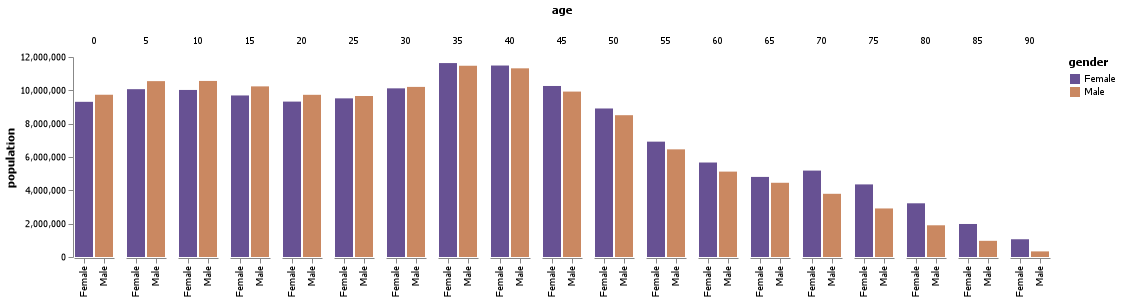

In [2]:
dataset("population") |>
@vlplot(
    height=500,
    width =300,
    :bar,
    transform=[
        {filter="datum.variable == 'LCOE'"},
        {calculate="datum.sex == 2 ? 'Female' : 'Male'", as="gender"}
    ],
    column="age:o",
    y={"sum(people)", axis={title="population", grid=false}},
    x={"gender:n", axis={title=""}},
    color={"gender:n", scale={range=["#675193", "#ca8861"]}},
    spacing=10,
    config={
        view={stroke=:transparent},
        axis={domainWidth=1}
    }
)



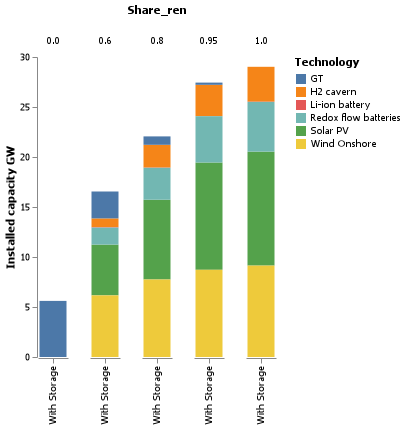

In [223]:
# importing initial analysis

# 
Per_tech_ren |>
stack |>
@vlplot(
    height=300,
    width =30,
    :bar,
    transform=[{calculate="datum.Extension == 1 ? 'With Storage' : 'Without'", as="Extension"},
                  {filter="datum.variable == 'Capacity_GW'"},
                  {filter="datum.value != 0"}],
    column="Share_ren:o",
    y={:value, axis={title="Installed capacity GW", grid=false}},
    x={"Extension:n", axis={title=""}},
    color={:Technology,
           scale={scheme="tableau10"},
           spacing=10},
    config={
        view={stroke=:transparent},
        axis={domainWidth=1}
    }

)

In [187]:
Per_tech_ren |>
stack

,Technology,Share_ren,Extension,variable,value
,String,String,Int64,String,Float64
1,Solar PV,0.0,1,Capacity_GW,0.0
2,Wind Onshore,0.0,1,Capacity_GW,0.0
3,Wind Offshore,0.0,1,Capacity_GW,0.0
4,H2 cavern,0.0,1,Capacity_GW,0.0
5,H2 tank,0.0,1,Capacity_GW,0.0
6,Li-ion battery,0.0,1,Capacity_GW,0.0
7,Redox flow batteries,0.0,1,Capacity_GW,0.0
8,Biogas,0.0,1,Capacity_GW,0.0
9,Brown coal,0.0,1,Capacity_GW,0.0


### Sensitivity analysis

In [28]:
#Get dual value
println(getdual(NotIntermittent[4,1000]))

#Get shadow prices
JuMP. shadow_price.(NotIntermittent[4,1000])

0.0


Old code

In [ ]:
Totals_ren |>
     stack |>         #Stacking data
     @vlplot(width=300)+
     @vlplot(transform=[{filter="datum.variable == 'LCOE'"}],
            mark=:line, 
            x=:Share_ren, 
            y=:value,
            color=:variable) |> display

# Extension 1 (Storage technologies)


Storage technologies
The extension will include options for investing into strage technologies such as Li-ion batteries or convesion of electical energy into fuels such as H2 or Biomethanol. Furter on fossil fuels will be removed to estimate amount of storage required to achieve fully renewable electricity production by 2050. 

### Further model improvements

Ideas for further model improvements:
+ Green transition requirements (100% of electric energy from Renewables)
+ Backup generation requirements
+ Including price of fuel and CO2 tax
+ Energy import and export
+ Subsidy for renewables
+ Storage 
+ Sell/buy 
+ Electric cars
+ Heat

# Name of extension

## Formualtion
waht, why we do this
what are articles/resources that support the idea

## Mathematical model
constraint

## Implementation
coding
constraints, varaibles, data (parameters)

## Sensitivity analysis

###  Sub-conclusion
